# ViT (Vision Transformer)

트랜스포머 구조가 인코더-디코더 구조를 띄고 있는 반면 ViT는 인코더만 가지고 있다.

## 1. 모델 구조

### 1.1. 비전 트랜스포머 인코더

일반 트랜스포머와 마찬가지로 전체적으로 멀티-헤드 어텐션 연산이 수행된다.

W,K,V는 $W.shape = K.shape = V.shape = (N,{d_{model} \over num\;head})$의 모양을 가지고 있다.

#### 1.1.1 인코더의 구조
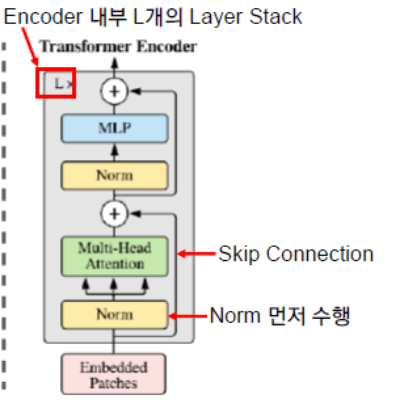

이 이전 데이터를 임베딩 해주는 과정이 있다.

앞선 트랜스포머는 일단 셀프 어텐션부터 했지만, ViT에서는 정규화를 먼저 한뒤 셀프 어텐션을 한다. 


#### 1.1.3 CLS 토큰 생성

추가적으로 입력단계에서 CLS라는 분류를 위한 토큰을 하나 임의로 생성한다. 이 토큰은 학습가능한 파라미터로 설정되고 아래의 패치 임베딩과 결합한다.

모양은
$$CLS.shape = (1,d_{model})$$

### 1.2. 이미지 패치 분할(임베딩)

앞서 설명했던 트랜스포머 구조는 임베딩 시 벡터형태[]의 입력을 받았다. 그리고 따로 설명을 달지 않았다.

이미지는 2차원 배열 형태[[],[]]이기 때문에 임베딩 방식이 다르다.

이미지 $x$가 $$x \in \mathbb{R}^{H\times W\times C} = 이미지는 \in (포함된다) \;\;공간\mathbb{R}^{H(이미지 높이)\times W(이미지 너비)\times C(이미지 채널)}$$ 라고 정의될 때*,



$x \in \mathbb{R}^{N\times(P^2\cdot C)}$ 로 변환(reshape)해준다.

이미지를 CNN연산 처럼 전체를 쓰는게 아닌, 하나의 이미지를 패치단위로 쪼개기 때문에 아래와 같은 변환이다.

$$ x_p \in \mathbb{R}^{H\times W\times C} \rightarrow x_p \in \mathbb{R}^{N\times(P^2\cdot C)} $$ 


#### = *3차원 이미지를 2차원으로 만드는 것이다. $\times$가 앞에는 3개 뒤에는 2개*

- $P$는 이미지를 자를 크기이다. 이미지의 입력과 관계없이 $(P,P)$크기로 패치를 나눈다.

- $N$은 이미지를 나눈 패치의 수이다. $N = HW/P^2$

---


*이미지는 높이x너비x차원(색상)의 3차원에 속해 있는 하나의 벡터로 정의된다. 

임의의 이미지가 (512,512,3)인 너비,높이가 512고 RGB채널을 가졌을 때 한 이미지가 3차원 텐서형을 가지며, 이 이미지를 1차원으로 변환하게 되면 $\mathbb{R}^{786,432}$차원의 하나의 벡터인 것

쉽게 생각하면 (512,512,3)일 때 바꿀수 있는 변수가 $512\times 512 \times 3 =786,432$개라 저런($\mathbb{R}^{512\times 512 \times 3}$) 차원을 가진다고 말하는 것이다.

#### 예시
RGB를 가진 $(512,512)$ 크기 이미지를 $P= 16$으로 나눈다고 해보자.

원래 이미지는 $(512,512,3)$이고 한 패치를 땐다고 가정하면 $x_p = (16,16,3)$이다.

그럼 이걸 $x_p \in \mathbb{R}^{N\times(P^2\cdot C)}$의 변환 한다고 해보면

 $x_p \in \mathbb{R}^{512\times 512\times 3} \rightarrow x_p \in \mathbb{R}^{{1024}\times 768}=\mathbb{R}^{{1024}\times(16^2\cdot 3)} $ 이므로 패치가 속한 차원이 축소됨을 알 수 있다.

### 1.3. 패치 임베딩


각 패치$x_p$는 **평탄화** 되어 $P^2\cdot C$차원의 벡터로 변형된다. (1차원 행렬 꼴)

평탄화 하는 이유는 트랜스포머 모델이 처리할수 있게 하기 위함이다. 그래서 하나의 패치$x_p$의 모양이 $(P\cdot P \cdot C)$ 의 1차원 행렬이 된다.

패치가 한개가 아닌 N개를 가지고 있기 때문에 최종적으로 이미지는 $N$개의 $P^2\cdot C$ 차원 벡터로 변형된다. ($x.shape = (H,W,C)\rightarrow (N,\;P^2\cdot C)$) 

이 말이 $$ x_p \in \mathbb{R}^{H\times W\times C} \rightarrow x_p \in \mathbb{R}^{N\times(P^2\cdot C)} $$ 이걸 말하는 것이다.



#### 예시

In [6]:
import numpy as np

# 임의의 이미지 데이터 생성 (예: 높이=512, 너비=512, 채널=3)
H, W, C = 512, 512, 3
image = np.random.rand(H, W, C)

# 패치 크기 설정 (예: 16x16)
P = 16
N = (H // P) * (W // P)  # 전체 패치 개수

# 이미지를 패치로 분할하고 평탄화
patches = []
for i in range(0, H, P):
    for j in range(0, W, P):
        patch = image[i:i+P, j:j+P, :]
        patch_flat = patch.reshape(-1)
        patches.append(patch_flat)

# 패치들을 하나의 행렬로 변환
patches_matrix = np.array(patches)  # Shape: (N, P^2 * C)

print("H:",H,", W:",W,", C:",C)
print("원본 이미지 차원:", image.shape)
print("N:",N ,", P*P*C",P*P*C)
print("변환된 패치 행렬 차원:", patches_matrix.shape)
print("==============================")
print("첫번째 패치의 모양", patches_matrix[0,:].shape)

H: 512 , W: 512 , C: 3
원본 이미지 차원: (512, 512, 3)
N: 1024 , P*P*C 768
변환된 패치 행렬 차원: (1024, 768)
첫번째 패치의 모양 (768,)


### 1.4. 포지셔널 인코딩 $(PE)$

트랜스포머와 마찬가지로 포지셔널 인코딩이 존재한다.

두가지 방식이 사용되는데
1. 트랜스포머 모델에서 사용한 홀수에 cos, 짝수에 sin을 더해주는 방법
2. 학습 가능한 위치 인코딩 방식(주로 사용)

모두 $X_p+PE$로 임베딩 된 결과에 더해진다.

CLS에도 위치 인코딩이 지정된다.

#### 1.4.1 학습 가능한 위치 인코딩

각 패치의 위치에 대한 정보를 제공하는 역할이다.

학습가능한 위치 인코딩은 $W,K,V$와 마찬가지로 가중치로서 존재한다.

모양은 $(N, P^2\cdot C)$ 초기화는 임의의 값이 사용된다. 학습하면서 최적화 되기 때문에 상관없다.

### 1.5 Self Attention

계산식은 트랜스포머의 계산식과 동일하다.

 $$Attention\;Value = softmax({QK^T\over \sqrt{D_k}})V= softmax({QK^T\over \sqrt{d_{model} \over num\;head}})V$$


#### 1.6 MLP $(Multi\;Layer\;Perceptron)$ = FeedForwardNetwork
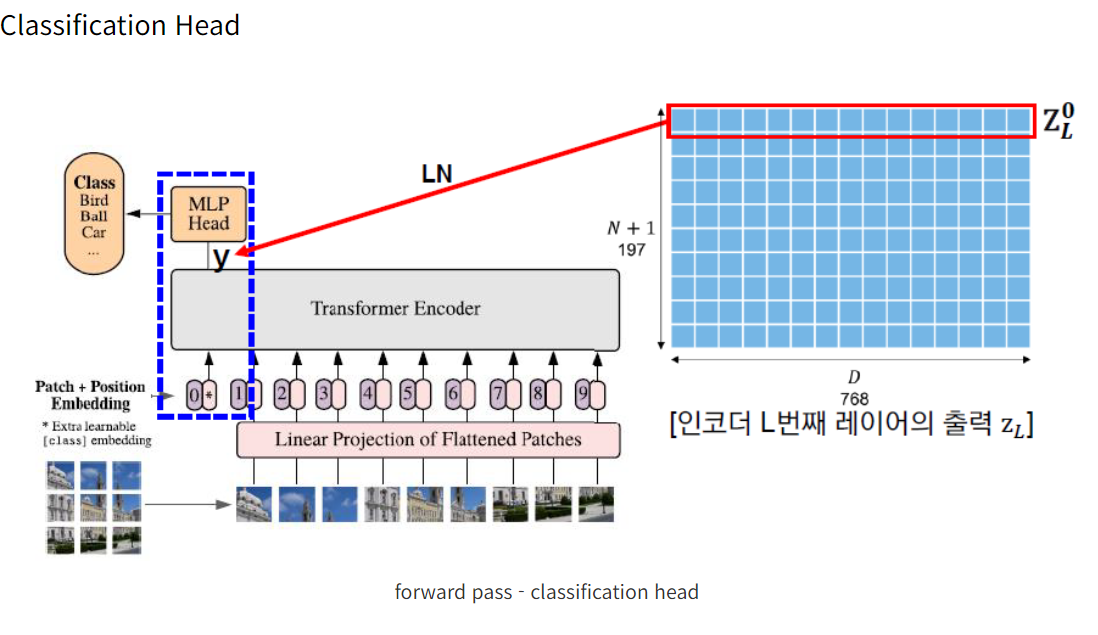

트랜스포머의 피드포워드 네트워크처럼 계산된 어텐션 벨류(V)를 활성화하고 넘겨주기 위한 계층이다. 

앞서 만들어진 CLS가 입력으로 들어간다.

역시 마찬가지로 선형변환(Linear)층이 사용되는데 ViT논문에서는 2개의 히든레이어와 GELU의 활성화 함수로 구성되어있다. 해당 논문에서 히든레이어 수를 (3072,4096,5120)로 옵션을 만들어 두었다. (아래 코드 참조)

논문에선 이 이후 분류 작업을 수행하기 때문에 세그멘테이션인 경우 추가적인 작업이 필요하다.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
#hidden_dim = 3072 or 4096 or 5120
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

### 1.7 Inductive Bias(유도 편향)

Inductive Bias는 학습과정에서 특정 패턴이나, 구조를 선호하도록 하는 가정 이라고 한다.

말이 어려운데 너무 편견없는 친구로 만들고 싶지 않다는 것이다.

CNN에서는 매우강한 유도편향을 가지고 있다고 한다. [지역적 특징(한 영역(kernel)내의 관계), 공간 계층구조(저수준->고수준 특징 추출), 이동 불변성(뽑아진 패턴이 있으면 위치가 상관없음)]

그런데 ViT에서는 이런 공간적인 유도편향이 이미지를 패치로 쪼개고 시퀀스 데이터(문자)처럼 해석하기 때문에 상대적으로 적다고 한다.

따라서 CNN처럼 저런 특징을 학습시키기 위해 몇가지 방법을 사용했다.

#### 1.7.1 대규모 데이터셋 사용

엄청나게 많은 데이터를 학습 시켰다.

#### 1.7.2 Hybrid Architecture(하이브리드 아키텍처)

입력을 CNN 특성맵으로 해버리는 경우
